## AG News: Causal Language Modeling

Dataset Source: https://www.kaggle.com/datasets/thedevastator/new-dataset-for-text-classification-ag-news

#### Install Necessary & Missing Libraries

In [1]:
%pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 394.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

#### Import Necessary Libraries

In [2]:
import os, sys, random, math

import pandas as pd

import matplotlib.pyplot as plt

import torch

import datasets
from datasets import ClassLabel, Dataset, DatasetDict

import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer, set_seed

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### Login For Access to HuggingFace

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

#### Display Library Versions

In [4]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)

        Python: 3.9.16
        Pandas: 1.4.4
      Datasets: 2.10.1
  Transformers: 4.26.1


#### Mount Google Drive to Notebook

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load Training Dataset

In [6]:
parent_dir = "/content/drive/MyDrive/Colab Notebooks/AG News"

train_data_file = os.path.join(parent_dir, "train.csv")

train_data = pd.read_csv(train_data_file, usecols=["text"])

train_data

,text
0,Wall St. Bears Claw Back Into the Black (Reute...
1,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,Iraq Halts Oil Exports from Main Southern Pipe...
4,"Oil prices soar to all-time record, posing new..."
...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...
119996,Renteria signing a top-shelf deal Red Sox gene...
119997,Saban not going to Dolphins yet The Miami Dolp...
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...


#### Load Evaluation Dataset

In [7]:
eval_data_file = os.path.join(parent_dir, "test.csv")

eval_data = pd.read_csv(eval_data_file, usecols=["text"])

eval_data

,text
0,Fears for T N pension after talks Unions repre...
1,The Race is On: Second Private Team Sets Launc...
2,Ky. Company Wins Grant to Study Peptides (AP) ...
3,Prediction Unit Helps Forecast Wildfires (AP) ...
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...
...,...
7595,Around the world Ukrainian presidential candid...
7596,Void is filled with Clement With the supply of...
7597,Martinez leaves bitter Like Roger Clemens did ...
7598,5 of arthritis patients in Singapore take Bext...


#### Visual: Histogram of Input Lengths

The maximum length of this dataset is approximately 177 words.


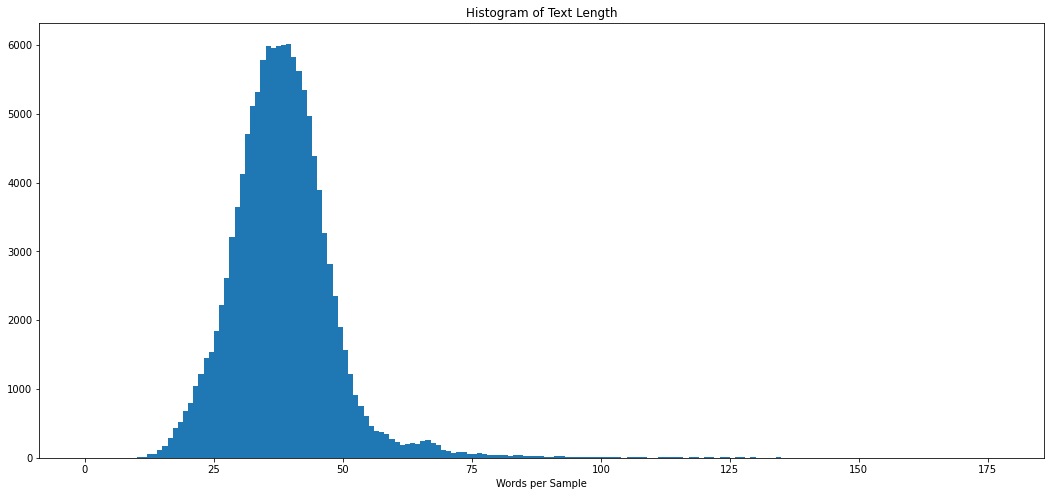

In [8]:
train_data['input_len'] = train_data['text'].str.split().str.len()
eval_data['input_len'] = eval_data['text'].str.split().str.len()

max_len = max(max(train_data['input_len']), max(eval_data['input_len']))
print(f"The maximum length of this dataset is approximately {max_len} words.")

input_lengths = pd.DataFrame()
input_lengths = pd.concat([train_data['input_len'], eval_data['input_len']])

n = max_len
input_lengths.hist(grid=False, figsize=(18,8), range=(0, n), bins=n)
plt.suptitle('')
plt.title('Histogram of Text Length')
plt.ylabel('')
plt.xlabel('Words per Sample')
plt.show()

#### Remove Unnecessary Features

In [9]:
train_data = train_data.drop(columns=["input_len"])
eval_data = eval_data.drop(columns=["input_len"])

train_data.info()
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    120000 non-null  object
dtypes: object(1)
memory usage: 937.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7600 non-null   object
dtypes: object(1)
memory usage: 59.5+ KB


#### Convert DataFrame to Dataset

In [10]:
training_dataset = Dataset.from_pandas(train_data)
evaluation_dataset = Dataset.from_pandas(eval_data)

#### Split Dataset into Training & Evaluation Datasets

In [11]:
ds = DatasetDict({
    'train' : training_dataset,
    'eval' : evaluation_dataset
})

print('Training data shape:', ds['train'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (120000, 1)
Eval data shape: (7600, 1)


#### Basic Values/Constants

In [12]:
BLOCK_SIZE = 128
MODEL_CKPT = "gpt2"

MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Causal_Language_Model-AG_News"
set_seed = 42

BATCH_SIZE = 1000 
NUM_OF_EPOCHS = 3

WEIGHT_DECAY = 0.01
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
LEARNING_RATE = 2e-5

DEVICE = torch.device("cuda")

#### Tokenize Entire Dataset

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, use_fast=True)

def tokenizer_function(samples):
    return tokenizer(samples["text"])

#### Apply Tokenizer Function to Entire Dataset

In [14]:
tokenized_ds = ds.map(tokenizer_function, 
                      batched=True,
                      remove_columns=ds["train"].column_names,)

print(tokenized_ds["train"])
print(tokenized_ds["eval"])

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 120000
})
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 7600
})


#### Preprocess Tokenized Dataset

In [15]:
def group_texts(samples):
    concatenated_examples = {k: sum(samples[k], []) for k in samples.keys()}
    total_length = len(concatenated_examples[list(samples.keys())[0]])
    total_length = (total_length // BLOCK_SIZE) * BLOCK_SIZE
    result = {
        k: [t[i : i + BLOCK_SIZE] for i in range(0, total_length, BLOCK_SIZE)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

#### Apply Preprocessing Function to Dataset

In [16]:
clm_ds = tokenized_ds.map(
    group_texts,
    batched=True,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/120000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7600 [00:00<?, ? examples/s]

#### Instantiate Model

In [17]:
model = (
    AutoModelForCausalLM.from_pretrained(MODEL_CKPT)
    ).to(DEVICE)

#### Define TrainingArguments

In [18]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    logging_strategy=STRATEGY,
    save_strategy=STRATEGY,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=NUM_OF_EPOCHS,
    report_to=REPORTS_TO,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator

In [19]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

#### Instantiate Trainer

In [20]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=clm_ds["train"],
    eval_dataset=clm_ds["eval"],
    data_collator=data_collator
)

Cloning https://huggingface.co/DunnBC22/gpt2-Causal_Language_Model-AG_News into local empty directory.


#### Train Model

In [21]:
train_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 48791
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18297
  Number of trainable parameters = 124439808
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,3.486500,3.218378
2,3.238800,3.150211
3,3.161000,3.131831


***** Running Evaluation *****
  Num examples = 3063
  Batch size = 8
Saving model checkpoint to gpt2-Causal_Language_Model-AG_News/checkpoint-6099
Configuration saved in gpt2-Causal_Language_Model-AG_News/checkpoint-6099/config.json
Configuration saved in gpt2-Causal_Language_Model-AG_News/checkpoint-6099/generation_config.json
Model weights saved in gpt2-Causal_Language_Model-AG_News/checkpoint-6099/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3063
  Batch size = 8
Saving model checkpoint to gpt2-Causal_Language_Model-AG_News/checkpoint-12198
Configuration saved in gpt2-Causal_Language_Model-AG_News/checkpoint-12198/config.json
Configuration saved in gpt2-Causal_Language_Model-AG_News/checkpoint-12198/generation_config.json
Model weights saved in gpt2-Causal_Language_Model-AG_News/checkpoint-12198/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3063
  Batch size = 8
Saving model checkpoint to gpt2-Causal_Language_Model-AG_News/checkpoint-18297
C

#### Evaluate Model

In [22]:
evaluation_results = trainer.evaluate()
print(f"Perplexity: {math.exp(evaluation_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 3063
  Batch size = 8


Perplexity: 22.92


#### Push Model to HuggingFace Hub

In [23]:
trainer.push_to_hub()

Saving model checkpoint to gpt2-Causal_Language_Model-AG_News
Configuration saved in gpt2-Causal_Language_Model-AG_News/config.json
Configuration saved in gpt2-Causal_Language_Model-AG_News/generation_config.json
Model weights saved in gpt2-Causal_Language_Model-AG_News/pytorch_model.bin
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/487M [00:00<?, ?B/s]

Upload file runs/Mar15_01-26-17_b684efef14b7/events.out.tfevents.1678843583.b684efef14b7.155.0: 100%|#########…

Upload file runs/Mar15_01-26-17_b684efef14b7/events.out.tfevents.1678849526.b684efef14b7.155.2: 100%|#########…

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/gpt2-Causal_Language_Model-AG_News
   88e8740..b54ed8f  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/gpt2-Causal_Language_Model-AG_News
   88e8740..b54ed8f  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Causal Language Modeling', 'type': 'text-generation'}}
To https://huggingface.co/DunnBC22/gpt2-Causal_Language_Model-AG_News
   b54ed8f..6170af9  main -> main

   b54ed8f..6170af9  main -> main



'https://huggingface.co/DunnBC22/gpt2-Causal_Language_Model-AG_News/commit/b54ed8fb0222352a1104688218de91f8fa5b7b9c'

### Notes & Other Takeaways From This Project
****
- This is definitely an improvement over the distilGPT2 version of this model, but I would still prefer better results.
****

### Citations
- Model Checkpoint
  - @article{radford2019language,
  title={Language Models are Unsupervised Multitask Learners},
  author={Radford, Alec and Wu, Jeff and Child, Rewon and Luan, David and Amodei, Dario and Sutskever, Ilya},
  year={2019}
}

- Metric (Perplexity)
  - @article{jelinek1977perplexity,
title={Perplexity—a measure of the difficulty of speech recognition tasks},
author={Jelinek, Fred and Mercer, Robert L and Bahl, Lalit R and Baker, James K},
journal={The Journal of the Acoustical Society of America},
volume={62},
number={S1},
pages={S63--S63},
year={1977},
publisher={Acoustical Society of America}
}